<a href="https://colab.research.google.com/github/disney-snoopy/SmArtGenerative/blob/master/notebooks/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [3]:
#Adding new search path
!pip install git+https://github.com/disney-snoopy/toolbox

  Cloning https://github.com/disney-snoopy/toolbox to /tmp/pip-req-build-v70iamvz
  Running command git clone -q https://github.com/disney-snoopy/toolbox /tmp/pip-req-build-v70iamvz
  Created wheel for toolbox: filename=toolbox-1.0-cp37-none-any.whl size=2552 sha256=73e1d2437f8d2a8fde33ada1ff3f9bc1070423b68945a7e7d224269527d15af5
  Stored in directory: /tmp/pip-ephem-wheel-cache-fdioqc5x/wheels/e0/e4/05/527fad3be42b4717820cf433a43a42d0fbdc7b4cee2cf8b4a7
Successfully built toolbox


In [4]:
#Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import copy

#torch libraries
import torch
from torchvision import models
from torch import nn
from torch import optim
import torch.nn.functional as F

#custom package
from toolbox.ntransfer import *

In [5]:
#for gpu computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
imsize = 512 if torch.cuda.is_available() else 128

# Loading images

In [7]:
#path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/pollock.jpg'
#path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/monet (2).jpg'
#path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/japanese_wave.jpeg'
#path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/starry_night.jpg'
#path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/renoir.jpg'
path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/kandinsky.jpg'
#path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/turner.png'
#path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/gogh_portrait.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/EIFFEL_TOWER.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/london_sky.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/le_wagon.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/doodle2.png'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/wagon_person.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/doodle.png'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/red_wagon2.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/ocean_rock.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/boris.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/boris_hanging.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/red_minibus.jpg'
path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/0Q8A5141V2.jpg'

In [8]:
tensor_style = loader(path_style, imsize).to(device, torch.float)
tensor_content = loader(path_content, imsize).to(device, torch.float)
tensor_noise = white_noise(imsize).to(device, torch.float)

# Defining loss

In [9]:
def gram_mat(f_map):
  a, b, c, d = f_map.shape
  f_map = f_map.view(a*b, c*d)
  gram = torch.mm(f_map, f_map.t())
  return gram.div(a*b*c*d)

In [10]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
  
  def forward(self, f_map):
    self.loss = F.mse_loss(f_map, self.target)
    return f_map

In [11]:
class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StlyeLoss, self).__init__()
    self.target = gram_mat(target).detach()
  
  def forward(self, f_map):
    gram = gram_mat(f_map)
    self.loss = F.mse_loss(gram, self.target)
    return f_map

# Calcularing Content Feature Maps

In [12]:
class Extract_content(nn.Module):
  #Extract__nn class returns the feature maps of the first 5 conv layers of vgg16.
  def __init__(self):
    super(Extract_content, self).__init__()
    vgg16 = models.vgg16(pretrained=True).features.eval().to(device, torch.float)
    layers = list(vgg16.children())
    self.conv1 = layers[0]
    self.conv2 = layers[2]
    self.conv3 = layers[5]
    self.conv4 = layers[7]
    self.conv5 = layers[10]
    self.maxpool = layers[4]
  def forward(self, x):
    out1 = self.conv1(x)
    out1 = F.relu(out1)
    out2 = self.conv2(out1)
    out2 = F.relu(out2)
    out3 = self.maxpool(out2)
    out3 = self.conv3(out3)
    out3 = F.relu(out3)
    out4 = self.conv4(out3)
    out4 = F.relu(out4)
    out5 = self.maxpool(out4)
    out5 = self.conv5(out5)
    out5 = F.relu(out5)
    f_maps = [out1.detach(), out2.detach(), out3.detach(), out4.detach(), out5.detach()]
    return f_maps

In [13]:
content_extraction = Extract_content()
content_fmaps = content_extraction.forward(tensor_content)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


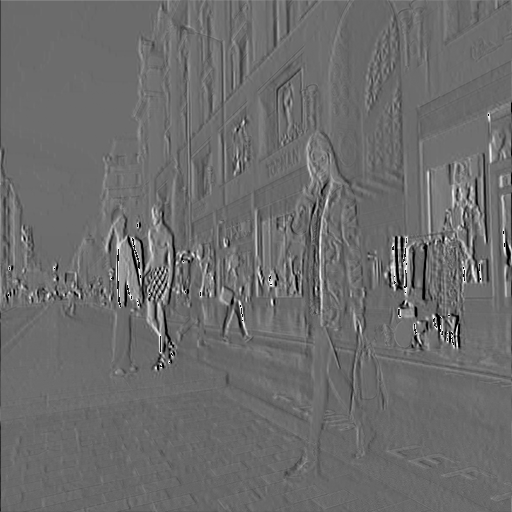

In [14]:
unloader(content_fmaps[0][0][0])

In [15]:
model = models.vgg16(pretrained=True).features.eval()
layers = list(model.children())

In [16]:
type(layers[0])

torch.nn.modules.conv.Conv2d

In [17]:
isinstance(layers[0], torch.nn.modules.conv.Conv2d)

True

In [18]:
resnet = models.resnet18(pretrained=True).eval()
res_layers = list(resnet.children())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [19]:
len(res_layers)

10

In [20]:
class ExtractContent(nn.Module):
  #Extract given number of conv feature maps
  def __init__(self,model = None,layer_count = 5):
    self.model = model
  def get_layers(self):
    if self.model == None:
      self.layers = list(models.vgg16(pretrained=True).eval().children())
      self.model = None
    else:
      assert isinstance(model, torch.nn.modules.container.Sequential)
      self.layers = list(self.model.features.eval().children())
      self.model = None
  def model_cons(self):
    conv_counter = 0
    for layer in self.layers:
      if isinstance(layer, torch.nn.modules.conv.Conv2d):
        

SyntaxError: ignored

In [ ]:
ec = ExtractContent()

In [ ]:
ec.get_layers()

In [ ]:
type(list(models.alexnet(pretrained=True).features.eval().children())[0])

# Calculate Style Feature Maps

In [21]:
class Extract_style(nn.Module):
  #Extract__nn class returns the feature maps of the first 5 conv layers of vgg16.
  def __init__(self):
    super(Extract_style, self).__init__()
    vgg16 = models.vgg16(pretrained=True).features.eval().to(device, torch.float)
    layers = list(vgg16.children())
    self.conv1 = layers[0]
    self.conv2 = layers[2]
    self.conv3 = layers[5]
    self.conv4 = layers[7]
    self.conv5 = layers[10]
    self.maxpool = layers[4]
  def forward(self, x):
    gram = []
    out = self.conv1(x)
    out = F.relu(out)
    gram.append(gram_mat(out).detach())
    out = self.conv2(out)
    out = F.relu(out)
    gram.append(gram_mat(out).detach())
    out = self.maxpool(out)
    out = self.conv3(out)
    out = F.relu(out)
    gram.append(gram_mat(out).detach())
    out = self.conv4(out)
    out = F.relu(out)
    gram.append(gram_mat(out).detach())
    out = self.maxpool(out)
    out = self.conv5(out)
    out = F.relu(out)
    gram.append(gram_mat(out).detach())
    return gram

In [22]:
style_extraction = Extract_style()
style_fmaps = style_extraction.forward(tensor_style)

# Style Transfer

In [23]:
class Extract_losses(nn.Module):
  #Extract__nn class returns the feature maps of the first 5 conv layers of vgg16.
  def __init__(self):
    super(Extract_losses, self).__init__()
    vgg16 = models.vgg16(pretrained=True).features.eval().to(device, torch.float)
    layers = list(vgg16.children())
    self.conv1 = layers[0]
    self.conv2 = layers[2]
    self.conv3 = layers[5]
    self.conv4 = layers[7]
    self.conv5 = layers[10]
    self.maxpool = layers[4]
  def forward(self, tensor_start, content_layers, style_layers, content_fmaps, style_fmaps):
    tensor_start = tensor_start
    content_loss = 0
    style_loss = 0

    #1st conv layer
    out = self.conv1(tensor_start)
    out = F.relu(out)
    if 1 in content_layers:
      loss = F.mse_loss(out, content_fmaps[0])
      content_loss += loss
    if 1 in style_layers:
      gram = gram_mat(out)
      loss = F.mse_loss(gram, style_fmaps[0])
      style_loss += loss
    
    #second conv layer
    out = self.conv2(out)
    out = F.relu(out)
    if 2 in content_layers:
      loss = F.mse_loss(out, content_fmaps[1])
      content_loss += loss

    if 2 in style_layers:
      gram = gram_mat(out)
      loss = F.mse_loss(gram, style_fmaps[1])
      style_loss += loss

    #third conv layer
    out = self.maxpool(out)
    out = self.conv3(out)
    out = F.relu(out)
    if 3 in content_layers:
      loss = F.mse_loss(out, content_fmaps[2])
      content_loss += loss

    if 3 in style_layers:
      gram = gram_mat(out)
      loss = F.mse_loss(gram, style_fmaps[2])
      style_loss += loss

    #fourth conv layer
    out = self.conv4(out)
    out = F.relu(out)
    if 4 in content_layers:
      loss = F.mse_loss(out, content_fmaps[3])
      content_loss += loss

    if 4 in style_layers:
      gram = gram_mat(out)
      loss = F.mse_loss(gram, style_fmaps[3])
      style_loss += loss

    #fifth conv layer
    out = self.maxpool(out)
    out = self.conv5(out)
    out = F.relu(out)
    if 5 in content_layers:
      loss = F.mse_loss(out, content_fmaps[4])
      content_loss += loss

    if 5 in style_layers:
      gram = gram_mat(out)
      loss = F.mse_loss(gram, style_fmaps[4])
      style_loss += loss

    return content_loss, style_loss

In [24]:
style_layers = [1,2,3,4]
content_layers = [5]

In [25]:
nn_loss = Extract_losses()
content_loss, style_loss = nn_loss.forward(tensor_start=tensor_noise, 
                                           content_layers=content_layers, 
                                           style_layers=style_layers, 
                                           content_fmaps=content_fmaps, 
                                           style_fmaps=style_fmaps)

In [26]:
content_loss

tensor(3.3249, device='cuda:0', grad_fn=<AddBackward0>)

In [38]:
def neural_transfer(tensor_start, content_fmaps, style_fmaps, content_layers, style_layers, epochs =  300, lr = 2e-2, style_weight = 1e4, content_weight = 1):
  loss_model = Extract_losses()
  tensor_input = tensor_start.to(device, torch.float).requires_grad_()
  opt = optim.Adam([tensor_input], lr = lr)
  output = []

  for epoch in range(epochs):
    content_loss , style_loss = loss_model.forward(tensor_start=tensor_input, 
                                                  content_layers=content_layers, 
                                                  style_layers=style_layers, 
                                                  content_fmaps=content_fmaps, 
                                                  style_fmaps=style_fmaps)
    content_loss = content_loss * content_weight
    style_loss = style_loss * style_weight
    loss = content_loss + style_loss

    loss.backward()
    if epoch % 20 == 0:
      print(f'Epoch: {epoch}, loss: {loss}')
      print(style_loss/content_loss)

    opt.step()
    opt.zero_grad()
    if epoch % 100 == 0:
      #output.append(tensor_input)
      output.append(tensor_input.clip(0, 1))

  tensor_input = tensor_input
  tensor_input = tensor_input.clip(0, 1)
  #tensor_input = tensor_input / torch.max(tensor_input)

  return output

In [39]:
output = neural_transfer(tensor_content, content_fmaps, style_fmaps, content_layers, style_layers, epochs=200)

Epoch: 0, loss: 0.4023478627204895
tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 20, loss: 0.10691064596176147
tensor(0.2930, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 40, loss: 0.05905785411596298
tensor(0.6952, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 60, loss: 0.046956125646829605
tensor(1.0801, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 80, loss: 0.04263097420334816
tensor(1.3587, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 100, loss: 0.040520597249269485
tensor(1.5521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 120, loss: 0.039330095052719116
tensor(1.6886, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 140, loss: 0.038557905703783035
tensor(1.7899, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 160, loss: 0.0380389466881752
tensor(1.8680, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 180, loss: 0.037699878215789795
tensor(1.9233, device='cuda:0', grad_fn=<DivBackward0>)


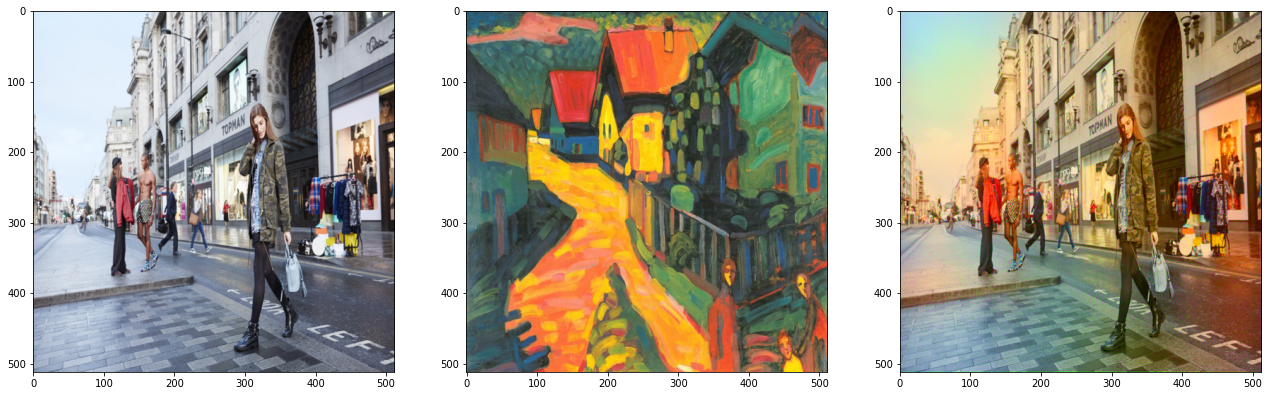

In [40]:
fig, axs = plt.subplots(1,3, figsize = (22, 16))
axs = axs.flatten()
axs[0].imshow(unloader(loader(path_content)))
axs[1].imshow(unloader(tensor_style))
axs[2].imshow(unloader(output[-1]));

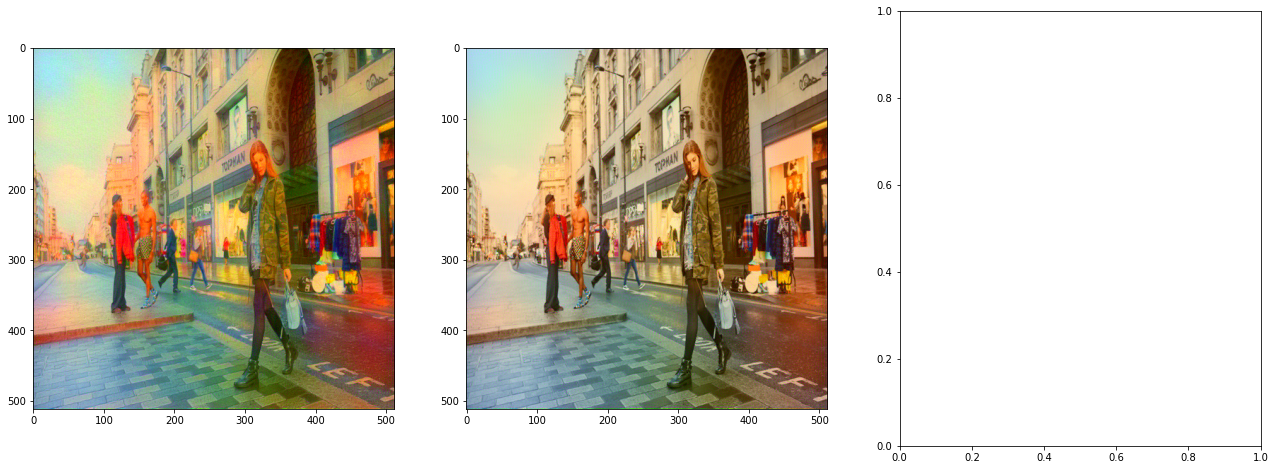

In [41]:
col = 3
row = len(output)//3 + 1
fig, axs = plt.subplots(row, col, figsize = (22, 8*row))
axs = axs.flatten()
for idx in range(len(output)):
  axs[idx].imshow(unloader(output[idx]))

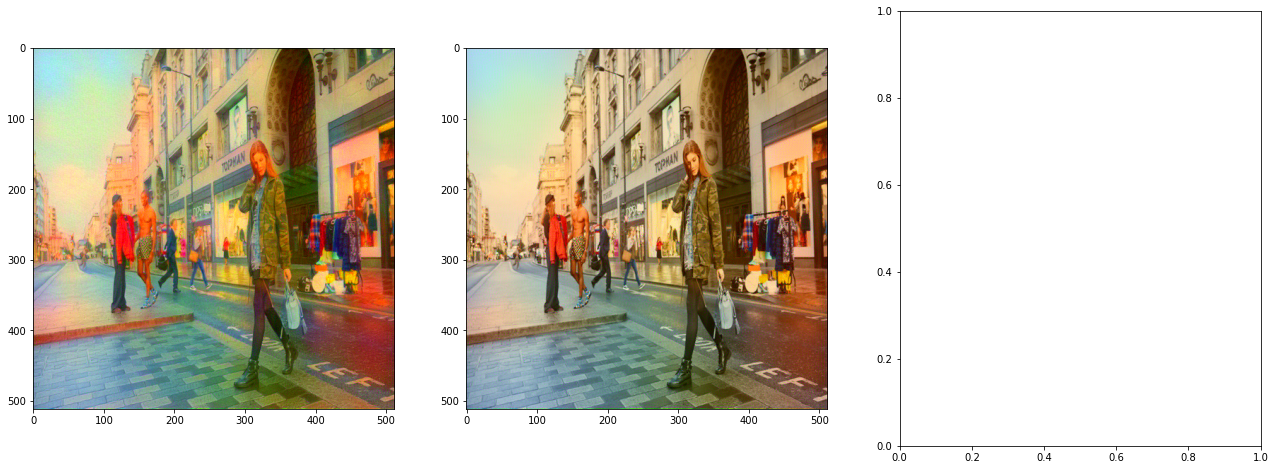

In [42]:
col = 3
row = len(output)//3 + 1
fig, axs = plt.subplots(row, col, figsize = (22, 8*row))
axs = axs.flatten()
for idx in range(len(output)):
  axs[idx].imshow(unloader(output[idx]))